In [108]:
import scanpy as sc
import sys
import numpy as np
import pandas as pd
import anndata as ad

# Load packages and classes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tiffslide
import seaborn as sns
import gget
import tifffile
import zarr

# MosaicDataset and BruceDataset classes allow loading and visualisation of the different data sources
from gbmhackathon import MosaicDataset, BruceDataset

# Download the data
Download the GBmap by running following command

In [109]:
adata = MosaicDataset.load_singlecell()

In [110]:
adata.obs_names

Index(['HK_G_058a.AAACAAGCACGGGCTAACTTTAGG-1',
       'HK_G_058a.AAACAAGCACTTTATGACTTTAGG-1',
       'HK_G_058a.AAACAAGCATGGATTGACTTTAGG-1',
       'HK_G_058a.AAACAAGCATGGCGCAACTTTAGG-1',
       'HK_G_058a.AAACCAATCAAGGTCGACTTTAGG-1',
       'HK_G_058a.AAACCAATCAGCGAATACTTTAGG-1',
       'HK_G_058a.AAACCAATCGGTAAACACTTTAGG-1',
       'HK_G_058a.AAACCAATCTAAATCCACTTTAGG-1',
       'HK_G_058a.AAACCAATCTTTAGCGACTTTAGG-1',
       'HK_G_058a.AAACCAGGTACGGGCAACTTTAGG-1',
       ...
       'HK_G_057a.TTTGGCGGTCATGATCATTCGGTT-1',
       'HK_G_057a.TTTGGCGGTGACCTATATTCGGTT-1',
       'HK_G_057a.TTTGGCGGTTTGAGCTATTCGGTT-1',
       'HK_G_057a.TTTGTGAGTACGCACCATTCGGTT-1',
       'HK_G_057a.TTTGTGAGTATGTTGCATTCGGTT-1',
       'HK_G_057a.TTTGTGAGTCACCAGCATTCGGTT-1',
       'HK_G_057a.TTTGTGAGTCACGATTATTCGGTT-1',
       'HK_G_057a.TTTGTGAGTGATTAGGATTCGGTT-1',
       'HK_G_057a.TTTGTGAGTGTCCAGCATTCGGTT-1',
       'HK_G_057a.TTTGTGAGTGTTAGCTATTCGGTT-1'],
      dtype='object', length=620451)

# Clone scFoundation repo

Git clone scFoundation in scripts. Once it is cloned, modifiy line 59 and 116 of scFoundation/model/get_embedding.py as follows:

- line 59: `gene_list_df = pd.read_csv('../scFoundation/OS_scRNA_gene_index.19264.tsv', header=0, delimiter='\t')`
- line 116: `ckpt_path = '../scFoundation/model/models/models.ckpt'`

# Instructions
In the following we are going to get the embeddings from your adata. You can go on cell by cell for the first run. Once you have ran once the whole notebook, you will have the embedding file saved in results. Once you have the embedding, you do not need to re-run everything. It suffices to go to the last part of the notebook. Note that at some step I downsampled the size to 10% of the original data, for the sake of speeding up the inference process. You can augment/delete that step once you made sure everything works fine. 

# Visualise the data

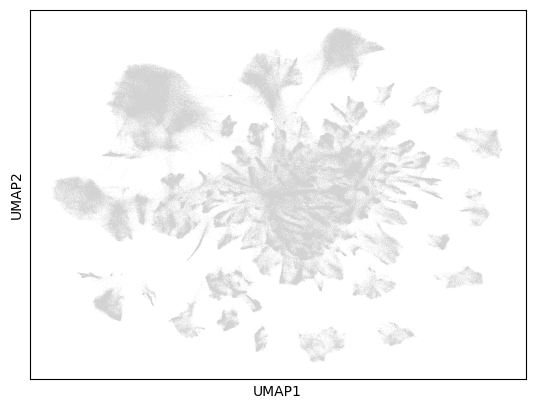

In [5]:
sc.pl.umap(adata)

# Prepare the adata
Steps:
1. Ensure the genes names are Ensemble IDs (skip if already so)
2. Convert AnnData to DataFrame
3. Reindexing of the gene names

### Gene names must be Ensembl ID (optional if it is already the case)

scFoundation requires your adata to have 19'264 genes. They have defined themselves this list of genes based on relevance. They require these genes to be named using Ensembl ID. My dataset did not have Ensemble ID names so I had to do the transfer first. If your adata is already using Ensembl ID, go to the next step. 

In [11]:
import mygene
import pandas as pd
import anndata as ad

# Initialize the MyGeneInfo object
mg = mygene.MyGeneInfo()

# Assuming adata is your AnnData object and is already loaded
# Example: adata = ad.read_h5ad('path_to_your_anndata.h5ad')

# Convert Ensembl IDs in adata to a list
ensembl_ids = adata.var_names.to_list()

# Query MyGeneInfo for the gene symbols
gene_info = mg.querymany(ensembl_ids, scopes='ensembl.gene', fields='symbol', species='human', as_dataframe=True)

# Handle duplicate hits by keeping the first occurrence
gene_info = gene_info[~gene_info.index.duplicated(keep='first')]

# Print the columns and the first few rows of the DataFrame for debugging
print("Columns in gene_info DataFrame:", gene_info.columns)
print(gene_info.head())

# Ensure there are no missing Ensembl IDs in adata.var_names
missing_ids = set(ensembl_ids) - set(gene_info.index)
if missing_ids:
    print(f"Warning: {len(missing_ids)} Ensembl IDs not found in gene_info")
    
# Map the Ensembl IDs in the AnnData object to gene symbols
adata.var['symbol'] = adata.var_names.map(gene_info['symbol'])

# Update the AnnData object's index to use gene symbols
adata.var_names = adata.var['symbol']

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
17842 input query terms found no hit:	['A2M', 'A2ML1', 'A3GALT2', 'A4GALT', 'AAAS', 'AACS', 'AADAT', 'AAGAB', 'AAK1', 'AAMDC', 'AAMP', 'AA


Columns in gene_info DataFrame: Index(['notfound'], dtype='object')
         notfound
query            
A2M          True
A2ML1        True
A3GALT2      True
A4GALT       True
AAAS         True


KeyError: 'symbol'

In [12]:
# Remove duplicate gene names
def remove_duplicate_var_indices(adata):
    # Extract the var index
    var_index = adata.var.index
    
    # Find duplicates
    duplicates = var_index[var_index.duplicated(keep='first')]
    
    # Drop duplicates
    adata = adata[:, ~var_index.isin(duplicates)]
    
    # Optionally print the number of removed variables
    print(f"Removed {len(duplicates)} variables with duplicate indices.")
    
    return adata

# Apply the function to your AnnData object
adata = remove_duplicate_var_indices(adata)

Removed 0 variables with duplicate indices.


In [13]:
# Ensure no variable indices are NaNs
def replace_nan_var_indices(adata):
    # Replace NaN in the var index with a placeholder
    adata.var.index = adata.var.index.fillna('unknown')
    
    # Ensure indices are unique after replacement
    if not adata.var.index.is_unique:
        raise ValueError("Indices are still not unique after replacing NaN.")
    
    return adata

# Apply the function to your AnnData object
adata = replace_nan_var_indices(adata)

### Convert the anndata to a DataFrame (required)

scFoundation is going to use the DataFrame version for the rest of his analysis. This step is required.

In [14]:
def prepare_adata_for_selection(adata):
    # Convert the AnnData matrix to a DataFrame
    X_df = pd.DataFrame(
        adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X,
        index=adata.obs_names,
        columns=adata.var_names
    )
    return X_df

In [15]:
X_df = prepare_adata_for_selection(adata)

### Reindexing of the gene names

scFoundation requires a certain indexing for the gene names. A few functions exist and can be used as is to transform the DataFrame you have saved previously for your analysis. 

In [16]:
def main_gene_selection(X_df, gene_list):
    """
    Describe:
        rebuild the input adata to select target genes encode protein 
    Parameters:
        adata->`~anndata.AnnData` object: adata with var index_name by gene symbol
        gene_list->list: wanted target gene 
    Returns:
        adata_new->`~anndata.AnnData` object
        to_fill_columns->list: zero padding gene
    """
    to_fill_columns = list(set(gene_list) - set(X_df.columns))
    padding_df = pd.DataFrame(np.zeros((X_df.shape[0], len(to_fill_columns))), 
                              columns=to_fill_columns, 
                              index=X_df.index)
    X_df = pd.DataFrame(np.concatenate([df.values for df in [X_df, padding_df]], axis=1), 
                        index=X_df.index, 
                        columns=list(X_df.columns) + list(padding_df.columns))
    X_df = X_df[gene_list]
    
    var = pd.DataFrame(index=X_df.columns)
    var['mask'] = [1 if i in to_fill_columns else 0 for i in list(var.index)]
    return X_df, to_fill_columns, var

In [22]:
gene_list_df = pd.read_csv('OS_scRNA_gene_index.19264.tsv', header=0, delimiter='\t')
gene_list = list(gene_list_df['gene_name'])
X_df, to_fill_columns, var = main_gene_selection(X_df, gene_list)

In [23]:
# Save processed csv file
#X_df.to_csv('scFoundation.csv')

KeyboardInterrupt: 

In [33]:
# Downsample the data. scFoundation works wiht max ~10'000 cells
downsampled_df = X_df.sample(frac=0.03, random_state=42)

In [34]:
downsampled_df.to_csv('undersampled.csv')

# Getting the embeddings

After the data has been prepared, we can train the model. The model cannot take too many cells at a time. In the paper, they say to not go over 10'000 cells at once. I tried with 300'000 cells (on my own dataset), my GPU managed to run 70'000 cells in 7 hours before crashing because of insufficient resources. In another try, I did it with 6'000 cells and it took me 15 minutes. 

In [101]:
# Load the prepared csv file
X_df = sc.read_csv('undersampled.csv')
X_df = X_df.to_df()

In [102]:
!python scfoundation/model/get_embedding.py --task_name Baron --input_type singlecell --output_type cell --pool_type all --tgthighres a5 --data_path undersampled.csv --save_path ./ --pre_normalized F --version rde

(18614, 19264)
Current working directory: /home/ec2-user/SageMaker/gbm_hackathon/notebooks/scFoundation_sc_embedding
{'mask_gene_name': False, 'gene_num': 19266, 'seq_len': 19266, 'encoder': {'hidden_dim': 768, 'depth': 12, 'heads': 12, 'dim_head': 64, 'seq_len': 19266, 'module_type': 'transformer', 'norm_first': False}, 'decoder': {'hidden_dim': 512, 'depth': 6, 'heads': 8, 'dim_head': 64, 'module_type': 'performer', 'seq_len': 19266, 'norm_first': False}, 'n_class': 104, 'pad_token_id': 103, 'mask_token_id': 102, 'bin_num': 100, 'bin_alpha': 1.0, 'rawcount': True, 'model': 'mae_autobin', 'test_valid_train_idx_dict': '/nfs_beijing/minsheng/data/os10000w-new/global_shuffle/meta.csv.train_set_idx_dict.pt', 'valid_data_path': '/nfs_beijing/minsheng/data/valid_count_10w.npz', 'num_tokens': 13, 'train_data_path': None, 'isPanA': False, 'isPlanA1': False, 'max_files_to_load': 5, 'bin_type': 'auto_bin', 'value_mask_prob': 0.3, 'zero_mask_prob': 0.03, 'replace_prob': 0.8, 'random_token_prob':

# Visualising embeddings

In [103]:
# Rename the output .npy file to undersampled.npy
refdf = X_df
imputeemb = np.load(f'embedding.npy')
imputeAdata = sc.AnnData(pd.DataFrame(imputeemb, index=refdf.index))
sc.pp.scale(imputeAdata)
sc.tl.pca(imputeAdata)
sc.pp.neighbors(imputeAdata)
sc.tl.umap(imputeAdata)

In [104]:
def transfer_obs(original_adata, subsampled_adata):
    common_indices = subsampled_adata.obs.index.intersection(original_adata.obs.index)
    subsampled_adata.obs = original_adata.obs.loc[common_indices].copy()
    return subsampled_adata

In [105]:
imputeAdata = transfer_obs(adata, imputeAdata)

### sc.pl.umap(imputeAdata, title ='Embeddings using scFoundation', color='orig.ident')

In [106]:
imputeAdata.obs['orig.ident'].unique()

['HK_G_059b', 'HK_G_020a', 'HK_G_101a', 'HK_G_077a', 'HK_G_023a', ..., 'HK_G_093a', 'HK_G_028a', 'HK_G_096b', 'HK_G_044b', 'HK_G_068a']
Length: 107
Categories (107, object): ['HK_G_001a', 'HK_G_002a', 'HK_G_003a', 'HK_G_004a', ..., 'HK_G_112a', 'HK_G_113b', 'HK_G_114a', 'HK_G_115b']

In [107]:
imputeAdata.var_names

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '3062', '3063', '3064', '3065', '3066', '3067', '3068', '3069', '3070',
       '3071'],
      dtype='object', length=3072)

In [99]:
imputeAdata.X

array([[-0.89770937, -0.7937836 ,  1.0597194 , ..., -1.8101486 ,
        -1.2352196 , -0.04971457],
       [ 1.3782251 ,  0.06948848,  0.8145396 , ...,  0.9352945 ,
        -0.8454181 ,  0.9297686 ],
       [-0.2733079 ,  0.13352998, -0.40221083, ...,  0.17310522,
        -0.88426876,  0.33421922],
       ...,
       [-0.8435509 ,  1.2420447 ,  0.03835081, ...,  0.6572947 ,
        -0.14903353, -0.02689913],
       [-0.80938643, -0.37455058,  0.722995  , ..., -1.5003006 ,
         0.31059122, -0.889958  ],
       [ 0.39489242, -0.95145184, -1.7831956 , ..., -0.3714798 ,
         0.44154048,  1.3456789 ]], dtype=float32)

In [100]:
df = pd.DataFrame(imputeAdata.X)#.select_dtypes(include = ['number'])
df['orig.ident'] = imputeAdata.obs.reset_index()['orig.ident']

df.groupby('orig.ident').mean()

/tmp/ipykernel_167364/4287134238.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('orig.ident').mean()


,0,1,2,3,4,5,6,7,8,9,...,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071
orig.ident,,,,,,,,,,,,,,,,,,,,,
HK_G_001a,0.336190,0.385292,0.333706,0.173731,0.629536,0.386042,0.439884,0.180448,0.576562,0.035230,...,-0.616800,-0.005743,-0.382128,-0.159410,0.656463,0.364551,0.790119,0.358670,0.502617,-0.119162
HK_G_002a,0.028438,-0.168383,-0.392499,-0.327847,-0.396680,-0.146993,-0.034785,-0.239215,-0.489325,0.068659,...,0.081531,0.288296,-0.268264,0.150155,-0.292857,-0.034160,-0.381069,0.154869,-0.294322,0.407858
HK_G_003a,-0.295325,-0.210509,-0.227748,0.100849,-0.288724,-0.210927,-0.670134,-0.344173,0.221042,-0.655856,...,0.355710,0.399715,0.795513,-0.123427,-0.599064,-0.264407,-0.214298,-0.701228,-0.131132,-0.386579
HK_G_004a,0.370436,-0.121149,0.362426,0.528192,0.280589,-0.228883,-0.164507,0.444432,0.325650,0.314234,...,-0.097582,-0.213123,0.666996,0.148799,0.093729,0.154384,0.141678,-0.032368,-0.128120,-0.042630
HK_G_005a,-0.634868,-0.102727,-0.044304,-0.937357,-0.933963,-0.304628,-0.621911,-0.102660,-0.878670,0.828074,...,0.129457,0.780229,-0.212062,-0.406623,0.294650,-0.577927,-0.305419,-0.190123,-0.046002,0.525203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HK_G_111b,0.540367,-0.667195,-0.567988,0.298478,0.729389,0.508031,0.551864,0.555050,0.312429,0.004300,...,0.573796,-0.189851,-0.194558,0.336249,0.197701,0.851067,-0.219837,0.302344,-0.251534,0.147617
HK_G_112a,0.164759,0.040914,-0.406832,-0.800881,-0.858191,-0.100882,0.277423,-0.237624,-1.077022,0.334624,...,-0.189587,0.254647,-0.708772,0.168204,-0.277703,-0.269086,-0.280402,0.388726,0.047850,0.370003
HK_G_113b,0.323832,-0.623976,-0.498313,0.089793,0.075936,0.275179,0.328689,0.051982,-0.336668,-0.094456,...,0.240276,-0.291046,-0.183889,0.394587,0.251453,0.052609,0.051019,0.876080,-0.047693,0.128737
